In [8]:
import pickle
from collections import namedtuple

import pandas as pd
import numpy as np
from numpy import pi as PI
import pymc3 as pm
import theano.tensor as tt

import matplotlib.pyplot as pl
import matplotlib.dates as mdates
from matplotlib import rcParams

from utils import Scaler

In [82]:
% matplotlib inline
rcParams['xtick.major.size'] = 8
rcParams['xtick.minor.size'] = 4
rcParams['xtick.minor.visible'] = True
rcParams['xtick.labelsize'] = 16
rcParams['ytick.labelsize'] = 16
rcParams['axes.labelsize'] = 16
rcParams['axes.titlesize'] = 18
years = mdates.YearLocator(day=15)
years2 = mdates.YearLocator(base=2, day=15)
months = mdates.MonthLocator(bymonthday=15)

In [104]:
def plot_component(axi, x, y, hpd_=None, obs=None, line_label=None, y_axis_label=None,
                  ax_title=None):
    
    if isinstance(obs, np.ndarray):
        axi.plot(x, obs, color='k', marker='.', linestyle=':',
                 markersize=15, label='observations')
    axi.plot(x, y, color='darkblue', label=line_label)
    if isinstance(hpd_, np.ndarray):
        axi.fill_between(x, hpd_[:, 0], hpd_[:, 1], color='steelblue',
                         alpha=0.5, label='95% CI')
    if y_axis_label:
        axi.set_ylabel(y_axis_label)
    axi.legend()
    if ax_title:
        axi.set_title(ax_title)
    axi.xaxis_date()
    axi.xaxis.set_major_locator(years)
    axi.xaxis.set_minor_locator(months)
    axi.tick_params(axis='x', labelrotation=30)
    axi.grid()


def make_scaler(X, scaler_name='std_scaler'):
    sclr = namedtuple('scaler_name', ['mean_', 'std_'])
    sclr.mean_ = X.mean(axis=0)
    sclr.std_ = X.std(axis=0)
    return sclr
    
def inverse_transform(X, scaler):
    return (scaler.std_ * X + scaler.mean_)


def plot_ts_components(trace, df_, y_obs, inv_transform=False, residual=False):
    ts_mod = trace.get_values('mu')
    ts_mod_mu = ts_mod.mean(axis=0)
    ts_mod_hpd = pm.hpd(ts_mod)
    ts_mod_trend = trace.get_values('trend')
    ts_mod_trend_mu = ts_mod_trend.mean(axis=0)
    ts_mod_trend_hpd = pm.hpd(ts_mod_trend)
    ts_mod_season = trace.get_values('season')
    ts_mod_season_mu = ts_mod_season.mean(axis=0)
    ts_mod_season_hpd = pm.hpd(ts_mod_season)
    if inv_transform:
        ts_mod_mu = scaler.inv_transform(ts_mod_mu)
        ts_mod_hpd = scaler.inv_transform(ts_mod_hpd)
        ts_mod_trend_hpd = scaler.inv_transform(ts_mod_trend_hpd)
        ts_mod_trend_mu = scaler.inv_transform(ts_mod_trend_mu)
        ts_mod_season_hpd = scaler.inv_transform(ts_mod_season_hpd)
        ts_mod_season_mu = scaler.inv_transform(ts_mod_season_mu)
        
    if residual:
        ts_mod_ar1 = trace.get_values('ar1')
        ts_mod_ar1_mu = ts_mod_ar1.mean(axis=0)
        ts_mod_ar1_hpd = pm.hpd(ts_mod_ar1)
        if inv_transform:
            ts_mod_ar1_hpd = scaler.inv_transform(ts_mod_ar1_hpd)
            ts_mod_ar1_mu = scaler.inv_transform(ts_mod_ar1_mu)
        nrows=4
    else: 
        nrows=3
    f, ax = pl.subplots(nrows=nrows, sharex=True, figsize=(12, nrows*5))
    plot_component(ax[0], df_.index, ts_mod_mu, hpd_=ts_mod_hpd,
                   obs=y_obs, line_label='model_mean',
                   y_axis_label='chl $(mg m^-3)$', ax_title='All Components')
    plot_component(ax[1], df_.index, ts_mod_trend_mu, hpd_=ts_mod_trend_hpd,
                   line_label='mean', y_axis_label='chl $(mg m^-3)$',
                   ax_title='Trend')
    plot_component(ax[2], df_.index, ts_mod_season_mu, hpd_=ts_mod_season_hpd,
                   line_label='mean', y_axis_label='chl $(mg m^-3)$',
                   ax_title='Season')
    if residual:
        plot_component(ax[3], df_.index, ts_mod_ar1_mu, hpd_=ts_mod_ar1_hpd,
                       line_label='mean', y_axis_label='chl $(mg m^-3)$',
                       ax_title='AR1')

In [94]:
def ts_model(x_, y_, n_fourier_comps=2, AR1_residual=True):
    wls = [2*np.pi *k / 12 for k in range(1, n_fourier_comps+1)]
    sinusoids = np.array([[np.cos(wli*x), np.sin(wli*x)] 
                          for wli in wls]).reshape(n_fourier_comps*2, -1).T
    with pm.Model() as m_ts:
        """This model includes missing data imputation"""
        # overall estimation
        nuMinusOne = pm.Exponential('nuMinusOne', 1/29)
        nu_ = nuMinusOne + 1
        lam_ = pm.Gamma('lam', 10, 2)

        slp_std = pm.HalfCauchy('slp_std', beta=2.5)
        itc_std = pm.HalfCauchy('itc_std', beta=2.5)
        # trend estimation
        slp = pm.Normal('slope', 0, slp_std)
        itc = pm.Normal('intercept', 0, itc_std)
        trend = pm.Deterministic('trend', itc + slp * x_)

        # seasonality estimation
        coefs_sd = pm.HalfCauchy('coefs_sd', beta=2)
        f_coefs = pm.Normal('fourier_coefs', mu=0, sd=coefs_sd, shape=n_fourier_comps*2)
        season = pm.Deterministic('season', tt.dot(sinusoids, f_coefs))

        mu_ = pm.Deterministic('mu', trend + season)
        
        if  AR1_residual:
            # residual estimation
            k_ = pm.Uniform('k', -1.1, 1.1)
            tau_ = pm.Gamma('tau', 10, 3)
            ar1 = pm.AR1('ar1', k=k_, tau_e=tau_, shape=y_npac.size)
            mu_ +=  ar1
        
        y_lik = pm.StudentT('y_lik', mu=mu_, lam=lam_, nu=nu_, observed=y_)
    return m_ts

In [12]:
df_s = pd.read_pickle('./pickleJar/df_stdzd.pkl')
df_ = pd.read_pickle('./pickleJar/df_raw.pkl')

In [13]:
scaler = Scaler()

In [14]:
scaler.fit(df_)

In [70]:
x = np.arange(df_s.shape[0])
y_s = np.ma.array(data=df_s.values, mask=df_s.isnull().values, fill_value=-999)

In [21]:
df_s.isnull().sum(), df_s.isnull().sum().sum()

(NPAC    5
 SPAC    5
 IO      7
 NATL    7
 SATL    7
 dtype: int64, 31)

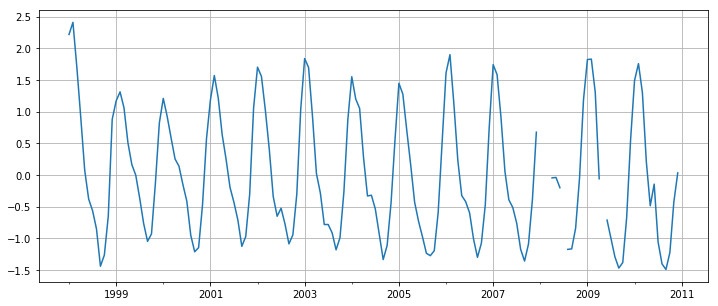

In [41]:
f, ax = pl.subplots(figsize=(12, 5))
df_s.NPAC.plot(ax=ax);
ax.xaxis_date()
ax.set_xlabel('')
ax.grid()

In [39]:
npac_column = df_s.columns.get_loc('NPAC')

In [69]:
y_npac = y_s[:, npac_column]

In [52]:
sinusoids.shapex

(156, 4)

### Model with Trend and Fourier Seasonality

In [95]:
m00 = ts_model(x, y_npac, AR1_residual=False)
with m00:
    trace_00 = pm.sample(5000, tune=5000, cores=2, chains=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [y_lik_missing, fourier_coefs, coefs_sd_log__, intercept, slope, itc_std_log__, slp_std_log__, lam_log__, nuMinusOne_log__]
100%|██████████| 10000/10000 [00:27<00:00, 364.54it/s]
There were 22 divergences after tuning. Increase `target_accept` or reparameterize.
There were 20 divergences after tuning. Increase `target_accept` or reparameterize.


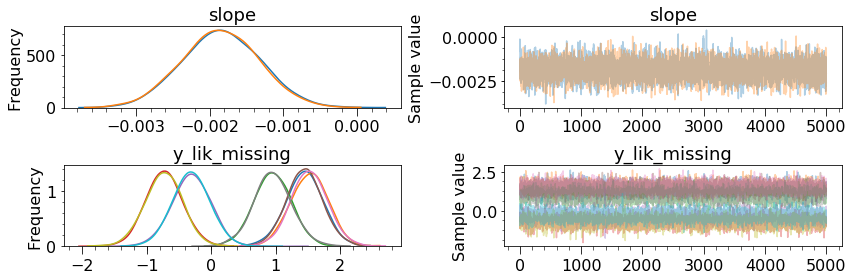

In [97]:
pm.traceplot(trace_00, varnames=['slope', 'y_lik_missing']);

In [74]:
with m0:
    trace_0 = pm.sample(5000, tune=5000, cores=2, chains=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [y_lik_missing, fourier_coefs, coefs_sd_log__, intercept, slope, itc_std_log__, slp_std_log__, lam_log__, nuMinusOne_log__]
100%|██████████| 10000/10000 [00:26<00:00, 379.79it/s]
There were 40 divergences after tuning. Increase `target_accept` or reparameterize.
There were 27 divergences after tuning. Increase `target_accept` or reparameterize.


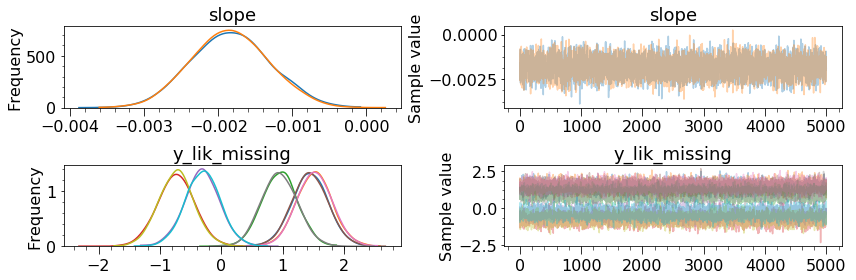

In [90]:
pm.traceplot(trace_0, varnames=['slope', 'y_lik_missing']);

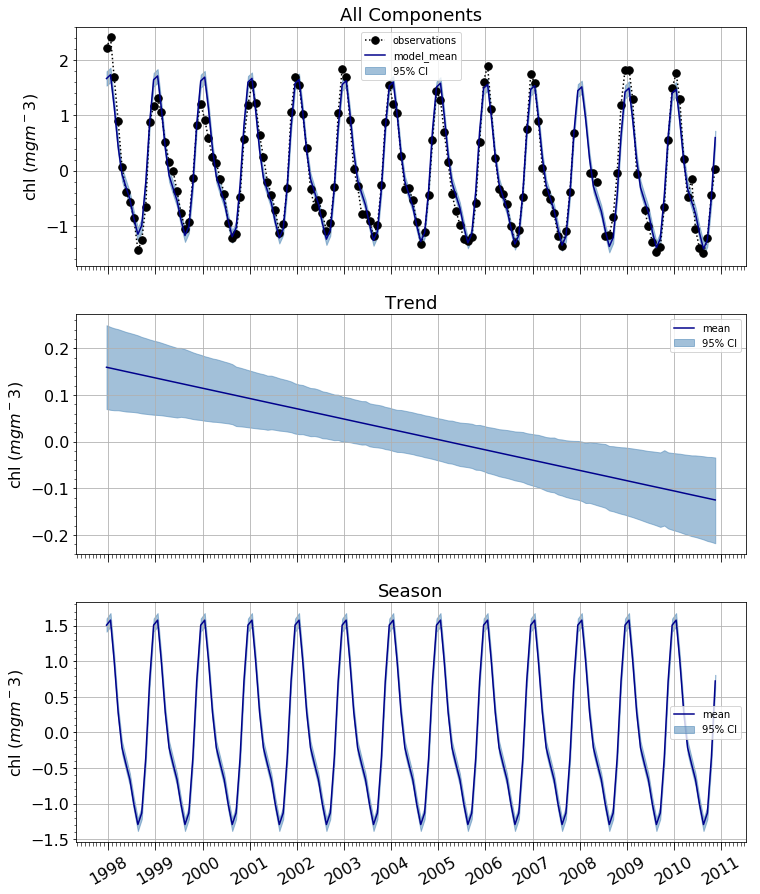

In [105]:
plot_ts_components(trace_0, df_=df_s[['NPAC']], y_obs=y_npac)

### Model with Trend, Seasonality, and AR(1) Residual

In [80]:
n_fourier_comps=2
wls = [2*np.pi *k / 12 for k in range(1, n_fourier_comps+1)]
sinusoids = np.array([[np.cos(wli*x), np.sin(wli*x)] 
                      for wli in wls]).reshape(n_fourier_comps*2, -1).T
with pm.Model() as m1:
    """This model includes missing data imputation"""
    # overall estimation
    nuMinusOne = pm.Exponential('nuMinusOne', 1/29)
    nu_ = nuMinusOne + 1
    lam_ = pm.Gamma('lam', 10, 2)
    
    slp_std = pm.HalfCauchy('slp_std', beta=2.5)
    itc_std = pm.HalfCauchy('itc_std', beta=2.5)
    
    # trend estimation
    slp = pm.Normal('slope', 0, slp_std)
    itc = pm.Normal('intercept', 0, itc_std)
    trend = pm.Deterministic('trend', itc + slp * x)
    
    # seasonality estimation
    coefs_sd = pm.HalfCauchy('coefs_sd', beta=2)
    f_coefs = pm.Normal('fourier_coefs', mu=0, sd=coefs_sd, shape=n_fourier_comps*2)
    season = pm.Deterministic('season', tt.dot(sinusoids, f_coefs))
    
    # residual estimation
    k_ = pm.Uniform('k', -1.1, 1.1)
    tau_ = pm.Gamma('tau', 10, 3)
    ar1 = pm.AR1('ar1', k=k_, tau_e=tau_, shape=y_npac.size)
    mu_ = pm.Deterministic('mu', trend + season + ar1)
    y_lik = pm.StudentT('y_lik', mu=mu_, lam=lam_, nu=nu_, observed=y_npac)

In [81]:
with m1:
    trace_1 = pm.sample(1000, tune=1000, cores=2, chains=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [y_lik_missing, ar1, tau_log__, k_interval__, fourier_coefs, coefs_sd_log__, intercept, slope, itc_std_log__, slp_std_log__, lam_log__, nuMinusOne_log__]
100%|██████████| 2000/2000 [00:26<00:00, 75.45it/s]
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


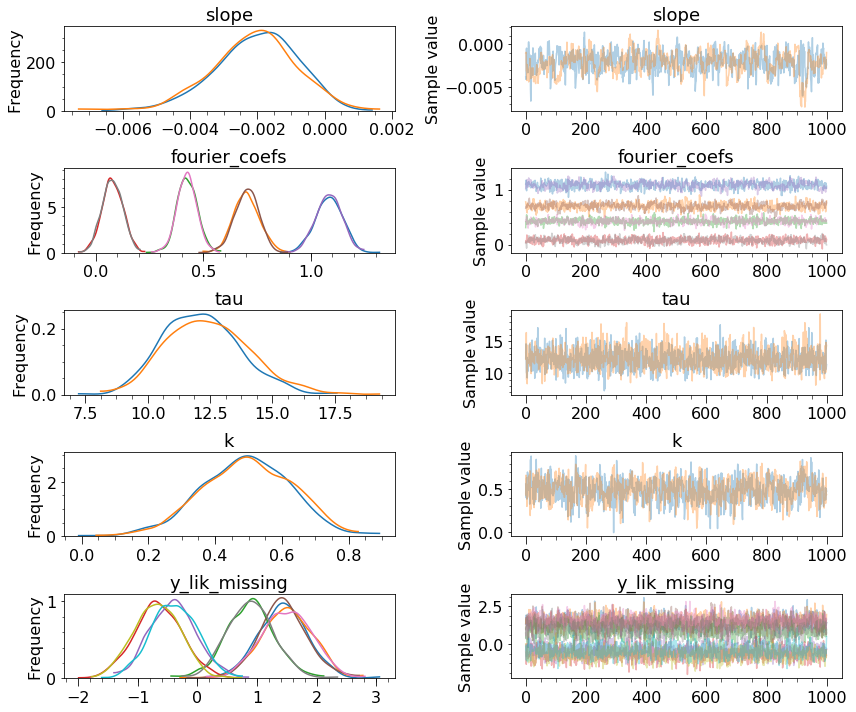

In [91]:
pm.traceplot(trace_1, varnames=['slope', 'fourier_coefs', 'tau', 'k',
                                'y_lik_missing']);

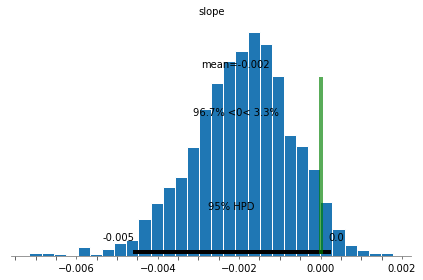

In [92]:
pm.plot_posterior(trace_1, varnames=['slope'], ref_val=0);

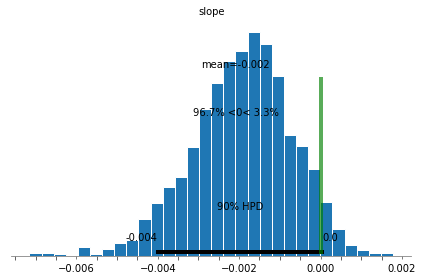

In [93]:
pm.plot_posterior(trace_1, varnames=['slope'], ref_val=0, alpha_level=0.1);

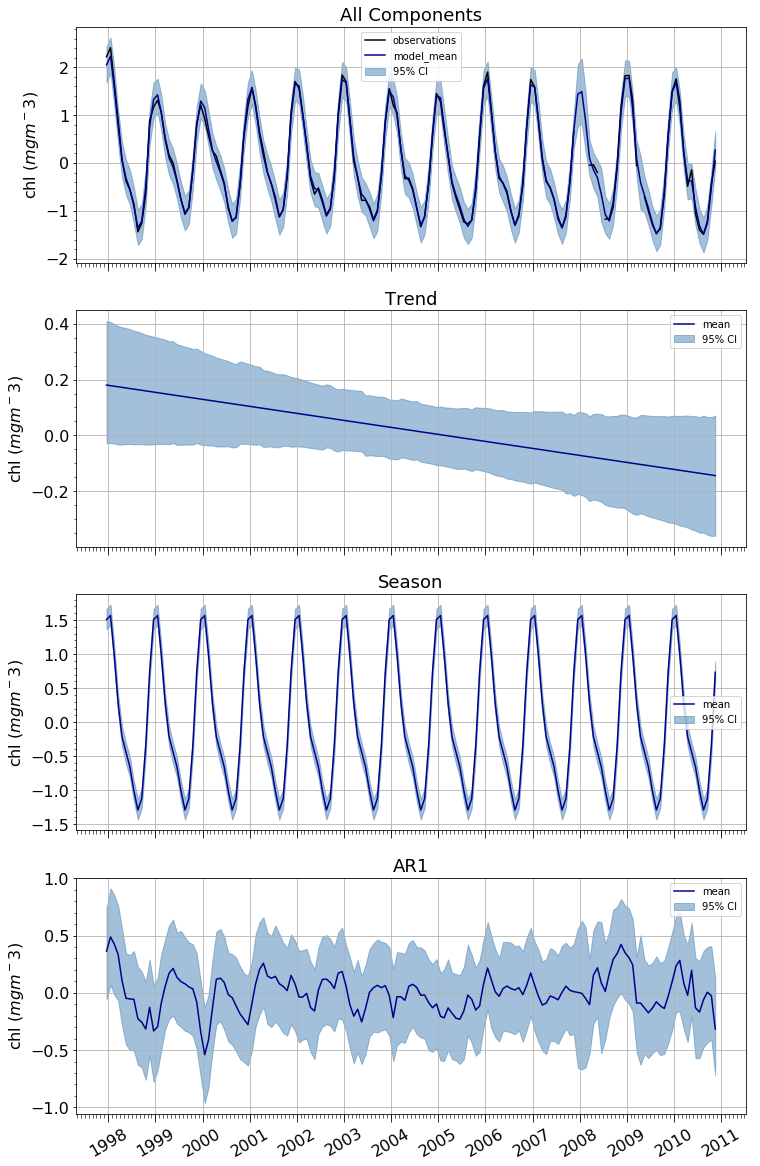

In [88]:
plot_ts_components(trace_1, df_=df_s[['NPAC']], y_obs=y_npac, residual=True)

### Hierarchical Partially Pooled Model

In [ ]:
n_regions = y_s.shape[1]
n_fourier_comps=2
wls = [2*np.pi *k / 12 for k in range(1, n_fourier_comps+1)]
sinusoids = np.array([[np.cos(wli*x), np.sin(wli*x)] 
                      for wli in wls]).reshape(n_fourier_comps*2, -1).T
with pm.Model() as hmf:
    """This model includes missing data imputation"""
    # overall estimation
    nuMinusOne = pm.Exponential('nuMinusOne', 1/29)
    nu_ = nuMinusOne + 1
    lam_ = pm.Gamma('lam', 10, 2)
    
    # hyperpriors: 
    hyp_fourcoef_mu = pm.Normal('hyp_fourcoef_mu', mu=0, sd=10)
    hyp_fourcoef_sd  = pm.HalfCauchy('hyp_fourcoef_b', beta=5)
    hyp_slp_mu = pm.Normal('hyp_slp_mu', mu=0, sd=10)
    hyp_slp_sd = pm.HalfCauchy('hyp_slp_sd', beta=5)
    hyp_itc_mu = pm.Normal('hyp_itc_mu', mu=0, sd=10)
    hyp_itc_sd = pm.HalfCauchy('hyp_itc_sd', beta=5)
    #hyp_tau_alpha = pm.HalfNormal('hyp_tau_alpha', sd=5)
    #hyp_tau_beta = pm.HalfNormal('hyp_tau_beta', sd=5)
    # seasonality estimation
    f_coefs_offsets = pm.Normal('fco', 0, 1, shape=(n_fourier_comps*2, n_regions))
    f_coefs = pm.Deterministic('f_coefs',
                               hyp_fourcoef_mu + f_coefs_offsets * hyp_fourcoef_sd
                              )
    season = pm.Deterministic('season', tt.dot(sinusoids, f_coefs))


    # trend estimation
    slp_offset = pm.Normal('slp_offset', mu=0, sd=1, shape=(1, n_regions))
    slp = pm.Deterministic('slope', hyp_slp_mu + slp_offset * hyp_slp_sd)
    #slp = pm.Normal('slope', mu=hyp_slp_mu, sd=hyp_slp_std, shape=(1, n_regions))
    itc_offset = pm.Normal('itc_offset', mu=0, sd=1, shape=(1, n_regions))
    itc = pm.Deterministic('intercept', hyp_itc_mu + itc_offset * hyp_itc_sd)
    #itc = pm.Normal('intercept', mu=hyp_itc_mu, sd=hyp_itc_std, shape=(1, n_regions))
    trend = pm.Deterministic('trend', itc + tt.dot(x, slp))

    # residual estimation
    k_ = pm.Uniform('k', -1.1, 1.1, shape=(1, n_regions))
    tau_ = pm.Gamma('tau', alpha=10, beta=3, shape=(1, n_regions))
    ar1 = pm.AR1('ar1', k=k_, tau_e=tau_, shape=(x.size, n_regions))
    mu_ = pm.Deterministic('mu', trend + season + ar1)
    y_lik = pm.StudentT('y_lik', mu=mu_, lam=lam_, nu=nu_, observed=y_s)

In [32]:
with hmf:
    trace_hmf = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [y_lik_missing, ar1, tau_log__, k_interval__, itc_offset, slp_offset, fco, hyp_itc_sd_log__, hyp_itc_mu, hyp_slp_sd_log__, hyp_slp_mu, hyp_fourcoef_b_log__, hyp_fourcoef_mu, lam_log__, nuMinusOne_log__]
100%|██████████| 1500/1500 [07:45<00:00,  3.22it/s]
The acceptance probability does not match the target. It is 0.9352115390889943, but should be close to 0.8. Try to increase the number of tuning steps.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The acceptance probability does not match the target. It is 0.9253912646837509, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9845922624632731, but should be close to 0.8. Try to increase the number of tuning steps.
The chain reached the maximum tree depth. Increase max_t

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f6248cd4160>,
      dtype=object)

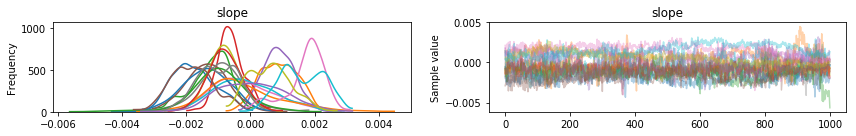

In [33]:
pm.traceplot(trace_hmf, varnames=['slope'])

In [ ]:
pm.